In [1]:
import pyarrow.parquet as pq

In [2]:
train_data = pq.read_pandas('data/train.parquet').to_pandas()

In [3]:
from mltoolbox.basic import *

In [69]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]

In [5]:
%matplotlib inline

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms

from pathlib import Path
import math, os

In [7]:
from mltoolbox.image import stats_dict

In [8]:
sz=512

In [9]:
train_meta = pd.read_csv('data/metadata_train.csv')
train_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [10]:
df = balance_dataset(train_meta, target_col='target')

In [11]:
train, valid = split_df(df)

In [12]:
df.target.value_counts()

1    8187
0    8187
Name: target, dtype: int64

In [13]:
train, valid = split_df(df)

In [14]:
from mltoolbox.image import *

In [15]:
SAMPLE_LENGTH = 800000
SAMPLE_TIME = 20e-3
SAMPLING_RATE = SAMPLE_LENGTH / SAMPLE_TIME

In [24]:
from scipy import fftpack

In [83]:
def shift_phase2zero(data):
    """
    smoothed_data = data.rolling(window=2001, center=True).mean().ewm(alpha=0.001
                                                                      ).mean()
                                                        # .bfill(limit=1000
                                                        # ).ffill(limit=1000)
    """
    sig_fft = fftpack.fft(data)
    sig_freq = fftpack.fftfreq(SAMPLE_LENGTH, 1 / SAMPLING_RATE)
    sig_fft[np.abs(sig_freq) > 100] = 0
    smoothed_data = fftpack.ifft(sig_fft)

    crossing_idx = np.where((smoothed_data[:-1] *
                             smoothed_data[1:]) <= 0)
    try:
        assert len(crossing_idx[0]) == 2
    except AssertionError:
        print(crossing_idx)
    for z_idx in crossing_idx[0]:
        if (smoothed_data[z_idx - 1000] < 0) and\
                (smoothed_data[z_idx + 1000] > 0):
            idx = z_idx
        else:
            pass
    return np.concatenate([data[idx:], data[:idx]])

In [17]:
from scipy import signal
from scipy.signal import butter

In [18]:
def high_pass_filter(signals, low_freq=1000, sample_fs=SAMPLING_RATE):
    sos = butter(10, low_freq, btype='hp', fs=sample_fs, output='sos')
    filtered_sig = signal.sosfilt(sos, signals)
    return filtered_sig

In [19]:
from pyts.image import GADF

In [20]:
gadf = GADF(image_size=sz)

In [ ]:
os.makedirs('data/gadf_grams')

cmap = plt.get_cmap('viridis')

def make_gadf(sig_idx):
    x = train_data.iloc[:, sig_idx]
    x = shift_phase2zero(x)
    x = high_pass_filter(x)
    x = gadf.fit_transform(np.expand_dims(x, axis=0))
    plt.imshow(transf.transform(x_samples[i]), cmap=cmap, origin='lower')
    plt.title(img_algo, fontsize=16)
    plt.savefig(img_dir, transparent=True)

In [84]:
class VSBDataset(Dataset):
    def __init__(self, df):
        self.num_files = df.shape[0]
        self.signal_id = df.signal_id.values
        self.labels = df.target.values
        self.data = train_data
        self.cmap = plt.get_cmap('viridis')

    def __len__(self):
        return self.num_files

    def __getitem__(self, idx):
        sig_idx = self.signal_id[idx]
        y = self.labels[idx]
        x = self.data.iloc[:, sig_idx]
        x = shift_phase2zero(x)
        x = high_pass_filter(x)
        x = gadf.fit_transform(np.expand_dims(x, axis=0))
        x = self.cmap(x[0])
        x = np.delete(x, 3, 2)
        x = normalize_image(x)
        x =  np.rollaxis(x, 2)
        return x, y

In [85]:
train_ds = VSBDataset(train)
valid_ds = VSBDataset(valid)

In [72]:
x, y = train_ds[900]
x.shape

(512, 512, 3)

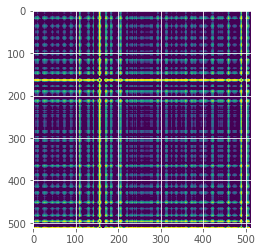

In [47]:
plt.imshow(x)

In [43]:
y

0

In [87]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [78]:
resnet = models.resnet34(pretrained=True)

In [86]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x.float().cuda()))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        # x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        # x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [80]:
model = Net().cuda()

In [33]:
%%prun
x, y = next(iter(valid_dl))

In [70]:
x.shape

torch.Size([64, 3, 512, 512])

In [49]:
y

0

In [50]:
x, y = next(iter(valid_dl))

In [57]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [58]:
y

tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0])

In [60]:
y_hat.squeeze().detach().cpu() > 0

tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1], dtype=torch.uint8)

In [61]:
from mltoolbox.dl import get_optimizer, save_model, load_model, lr_range_finder

In [62]:
from mltoolbox.dl import plot_lr

In [81]:
loss_criteria = F.binary_cross_entropy_with_logits

In [88]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=2)

KeyboardInterrupt: 